Import Libraries

In [114]:
# Import libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression


In [77]:
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, "cleandata", "combined_personas_sample.csv")

df = pd.read_csv(
    data_path,
    low_memory=False,
    na_values=["NaN", "NA", "N/A", "", " "],
    dtype={"UPM": str}
)
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ANIO                                  80000 non-null  int64  
 1   ID_PERSONA                            80000 non-null  object 
 2   LLAVE_ENTIDAD                         80000 non-null  int64  
 3   LLAVE_MUNICIPIO                       80000 non-null  int64  
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  80000 non-null  int64  
 5   LLAVE_LOCALIDAD                       80000 non-null  int64  
 6   CLAVE_LOCALIDAD_INEGI                 21039 non-null  float64
 7   ID_VIVIENDA                           80000 non-null  int64  
 8   ID_HOGAR                              24000 non-null  float64
 9   LLAVE_COBERTURA                       80000 non-null  int64  
 10  LLAVE_CLASEVIVIENDA                   80000 non-null  int64  
 11  LLAVE_SEXO     

In [104]:
# 1. Define continuous and categorical variables manually
continuous_vars = [
    'INGRESO', 'HORAS_TRABAJADAS', 'ESCOLARIDAD_ACUMULADA', 'ESCOLARIDAD', 'EDAD',
    'HIJOS_NACIDOS', 'HIJOS_VIVOS', 'HIJOS_FALLECIDOS'
]

categorical_vars = [
    'LLAVE_SEXO', 'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
    'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD', 'LLAVE_SERSALUD',
    'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION', 'LLAVE_HLENGUA',
    'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA', 'LLAVE_PERTEINDIGENA',
    'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR', 'LLAVE_ENTIDAD_ASISESCOLAR',
    'LLAVE_MUNICIPIO_ASISESCOLAR', 'LLAVE_TIETRASLADO_ESCOLAR',
    'LLAVE_MEDTRASLADO_ESCOLAR', 'LLAVE_NIVACAD', 'LLAVE_CARRERA',
    'LLAVE_ALFABETISMO', 'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A',
    'LLAVE_MUNICIPIO_RES5A', 'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL',
    'LLAVE_IDENTPAREJA', 'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
    'LLAVE_ACTECONOMICA', 'ACTIVIDAD_ECONOMICA_INEGI', 'LLAVE_PAIS_TRABAJO',
    'LLAVE_ENTIDAD_TRABAJO', 'LLAVE_MUNICIPIO_TRABAJO',
    'LLAVE_TIETRASLADO_TRABAJO', 'LLAVE_MEDTRASLADO_TRABAJO',
    'LLAVE_TAMLOC', 'ESTRATO', 'UPM', 'MERCADO_TRABAJO_LOCAL'
]

# 2. Convert types
for col in categorical_vars:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in continuous_vars:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # ensures float

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   ANIO                                  80000 non-null  int64   
 1   ID_PERSONA                            80000 non-null  object  
 2   LLAVE_ENTIDAD                         80000 non-null  int64   
 3   LLAVE_MUNICIPIO                       80000 non-null  int64   
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  80000 non-null  int64   
 5   LLAVE_LOCALIDAD                       80000 non-null  int64   
 6   CLAVE_LOCALIDAD_INEGI                 21039 non-null  float64 
 7   ID_VIVIENDA                           80000 non-null  int64   
 8   ID_HOGAR                              24000 non-null  float64 
 9   LLAVE_COBERTURA                       80000 non-null  int64   
 10  LLAVE_CLASEVIVIENDA                   80000 non-null  int64   
 11  LL

In [105]:
# Calculate the percentage of non-null values per column
null_percentage = np.round(100 - df.notnull().mean() * 100)

# Create a DataFrame to display the results
non_null_percentage_df = pd.DataFrame(null_percentage, columns=['Percentage of Null Values'])

# Print the DataFrame
print(non_null_percentage_df.to_string())

                                      Percentage of Null Values
ANIO                                                        0.0
ID_PERSONA                                                  0.0
LLAVE_ENTIDAD                                               0.0
LLAVE_MUNICIPIO                                             0.0
CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)                        0.0
LLAVE_LOCALIDAD                                             0.0
CLAVE_LOCALIDAD_INEGI                                      74.0
ID_VIVIENDA                                                 0.0
ID_HOGAR                                                   70.0
LLAVE_COBERTURA                                             0.0
LLAVE_CLASEVIVIENDA                                         0.0
LLAVE_SEXO                                                  0.0
LLAVE_PARENTESCO                                            0.0
LLAVE_IDENTMADRE                                            0.0
LLAVE_IDENTPADRE                        

Remove all columns with more than 5% missing values.

In [106]:
# Calculate the percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Filter out columns with more than 5% missing values
columns_to_keep = missing_percentage[missing_percentage <= 11].index

# Create a new DataFrame with only the columns to keep
df_filtered = df[columns_to_keep]

# Calculate the percentage of non-null values per column
null_percentage = np.round(100 - df_filtered.notnull().mean() * 100)

# Create a DataFrame to display the results
non_null_percentage_df = pd.DataFrame(null_percentage, columns=['Percentage of Null Values'])

# Print the DataFrame
print(non_null_percentage_df)

                                      Percentage of Null Values
ANIO                                                        0.0
ID_PERSONA                                                  0.0
LLAVE_ENTIDAD                                               0.0
LLAVE_MUNICIPIO                                             0.0
CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)                        0.0
LLAVE_LOCALIDAD                                             0.0
ID_VIVIENDA                                                 0.0
LLAVE_COBERTURA                                             0.0
LLAVE_CLASEVIVIENDA                                         0.0
LLAVE_SEXO                                                  0.0
LLAVE_PARENTESCO                                            0.0
LLAVE_IDENTMADRE                                            0.0
LLAVE_IDENTPADRE                                            0.0
LLAVE_PAIS_NAC                                              0.0
LLAVE_ENTIDAD_NAC                       

In [107]:
# Count the number of remaining rows
remaining_cols = df_filtered.shape[1]

# Print the number of remaining rows
print("Number of remaining columns after removing those with >10% missing values:", remaining_cols)

Number of remaining columns after removing those with >10% missing values: 58


Remove all rows with missing values

In [108]:
# Remove all rows with missing values
df_cleaned = df_filtered.dropna()

# Count the number of remaining rows
remaining_rows = df_cleaned.shape[0]

# Print the number of remaining rows
print("Number of remaining rows after removing rows with missing values:", remaining_rows)

Number of remaining rows after removing rows with missing values: 65861


Using df.info() and df.describe(), describe the remaining columns.

In [109]:
# Display information about the remaining columns
df_cleaned.info()

# Display descriptive statistics for the remaining columns
df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65861 entries, 8000 to 79999
Data columns (total 58 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   ANIO                                  65861 non-null  int64   
 1   ID_PERSONA                            65861 non-null  object  
 2   LLAVE_ENTIDAD                         65861 non-null  int64   
 3   LLAVE_MUNICIPIO                       65861 non-null  int64   
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  65861 non-null  int64   
 5   LLAVE_LOCALIDAD                       65861 non-null  int64   
 6   ID_VIVIENDA                           65861 non-null  int64   
 7   LLAVE_COBERTURA                       65861 non-null  int64   
 8   LLAVE_CLASEVIVIENDA                   65861 non-null  int64   
 9   LLAVE_SEXO                            65861 non-null  category
 10  LLAVE_PARENTESCO                      65861 non-null  category
 11 

,ANIO,LLAVE_ENTIDAD,LLAVE_MUNICIPIO,CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM),LLAVE_LOCALIDAD,ID_VIVIENDA,LLAVE_COBERTURA,LLAVE_CLASEVIVIENDA,FACTOR_EXP,EDAD,ESCOLARIDAD,ESCOLARIDAD_ACUMULADA,INGRESO
count,65861.000000,65861.000000,65861.000000,65861.000000,6.586100e+04,6.586100e+04,65861.000000,65861.000000,65861.000000,65861.000000,65861.000000,65861.000000,6.586100e+04
mean,2011.956697,17.728413,1077.098814,76.164969,2.610376e+06,2.012059e+15,1.030321,0.649975,7.904739,30.807640,2.982706,6.312552,7.632977e+03
std,6.936921,7.885532,759.516520,99.566432,5.774933e+06,7.012302e+12,0.943294,1.090415,12.516898,20.411292,1.810090,4.669689,7.793284e+05
min,2000.000000,1.000000,1.000000,1.000000,0.000000e+00,2.000000e+15,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
25%,2010.000000,12.000000,403.000000,17.000000,0.000000e+00,2.010000e+15,0.000000,0.000000,2.000000,14.000000,2.000000,2.000000,0.000000e+00
50%,2015.000000,16.000000,894.000000,42.000000,0.000000e+00,2.015110e+15,1.000000,0.000000,4.000000,27.000000,3.000000,6.000000,0.000000e+00
75%,2015.000000,23.000000,1804.000000,95.000000,2.801390e+05,2.015302e+15,2.000000,1.000000,9.000000,44.000000,4.000000,9.000000,1.500000e+03
max,2020.000000,32.000000,2469.000000,570.000000,2.455004e+07,2.020321e+15,2.000000,10.000000,646.000000,110.000000,9.000000,24.000000,1.000000e+08


I'll start by spliting the data in train and test sets.

In [115]:
# Define the features (X) and target (y)
X = df.drop(columns=['INGRESO'])
y = df['INGRESO']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (72000, 65)
X_test shape: (8000, 65)
y_train shape: (72000,)
y_test shape: (8000,)


Education has a high NA rate. so Im gonna  compute the median value on the training set and
use it to fill the missing values in the training set.

In [116]:
median = X_train["ESCOLARIDAD_ACUMULADA"].median()
print(median)

6.0


Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.
Here is how to use it. First, you need to create a SimpleImputer instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute:

In [123]:
imputer = SimpleImputer(strategy='median')
X_train['ESCOLARIDAD_ACUMULADA'] = imputer.fit_transform(X_train[['ESCOLARIDAD_ACUMULADA']])
#X_test['ESCOLARIDAD_ACUMULADA'] = imputer.transform(X_test[['ESCOLARIDAD_ACUMULADA']])

Variables Selection

In [124]:
X_train.columns

Index(['ANIO', 'ID_PERSONA', 'LLAVE_ENTIDAD', 'LLAVE_MUNICIPIO',
       'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_LOCALIDAD',
       'CLAVE_LOCALIDAD_INEGI', 'ID_VIVIENDA', 'ID_HOGAR', 'LLAVE_COBERTURA',
       'LLAVE_CLASEVIVIENDA', 'LLAVE_SEXO', 'LLAVE_PARENTESCO',
       'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE', 'LLAVE_PAIS_NAC',
       'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD', 'LLAVE_SERSALUD',
       'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION', 'LLAVE_HLENGUA',
       'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA',
       'LLAVE_PERTEINDIGENA', 'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR',
       'LLAVE_ENTIDAD_ASISESCOLAR', 'LLAVE_MUNICIPIO_ASISESCOLAR',
       'LLAVE_TIETRASLADO_ESCOLAR', 'LLAVE_MEDTRASLADO_ESCOLAR',
       'LLAVE_NIVACAD', 'LLAVE_CARRERA', 'LLAVE_ALFABETISMO',
       'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A', 'LLAVE_MUNICIPIO_RES5A',
       'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL', 'LLAVE_IDENTPAREJA',
       'LLAVE_ACTPRIMARIA', 'LLAVE_

Data Exploration

In [125]:
# Step 1: Concatenate X_train and y_train 
train_data = pd.concat([X_train, y_train], axis=1)

In [126]:
# 1) Setup
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 2) Define continuous variables
continuous_vars = [
    "INGRESO", "HORAS_TRABAJADAS", "ESCOLARIDAD_ACUMULADA", "EDAD",
    "LLAVE_TIETRASLADO_TRABAJO", "FACTOR_EXP", "NUMPERSONA",
    "HIJOS_NACIDOS", "HIJOS_VIVOS", "HIJOS_FALLECIDOS"
]

# 3) Define categorical variables as the remaining columns
all_columns = train_data.columns.tolist()
categorical_vars = list(set(all_columns) - set(continuous_vars))

# 4) Force types 
#train data
train_data[continuous_vars] = train_data[continuous_vars].astype(float)
train_data[categorical_vars] = train_data[categorical_vars].astype("category")

#test data
train_data[continuous_vars] = train_data[continuous_vars].astype(float)
train_data[categorical_vars] = train_data[categorical_vars].astype("category")

# 5) Done!
print("✅ Continuous Variables:", continuous_vars)
print("\n✅ Categorical Variables:", categorical_vars)

✅ Continuous Variables: ['INGRESO', 'HORAS_TRABAJADAS', 'ESCOLARIDAD_ACUMULADA', 'EDAD', 'LLAVE_TIETRASLADO_TRABAJO', 'FACTOR_EXP', 'NUMPERSONA', 'HIJOS_NACIDOS', 'HIJOS_VIVOS', 'HIJOS_FALLECIDOS']

✅ Categorical Variables: ['ID_VIVIENDA', 'LLAVE_SITTRA', 'LLAVE_ENTIDAD_RES5A', 'ACTIVIDAD_ECONOMICA_INEGI', 'LLAVE_HESPANOL', 'LLAVE_PAIS_TRABAJO', 'LLAVE_NACIONALIDAD', 'LLAVE_CLASEVIVIENDA', 'LLAVE_ENTIDAD_NAC', 'LLAVE_MUNICIPIO_ASISESCOLAR', 'LLAVE_ACTPRIMARIA', 'LLAVE_ALFABETISMO', 'LLAVE_RELIGION', 'ID_PERSONA', 'LLAVE_IDENTMADRE', 'LLAVE_PERTEINDIGENA', 'LLAVE_MUNICIPIO_RES5A', 'LLAVE_TAMLOC', 'ESCOLARIDAD', 'LLAVE_NIVACAD', 'LLAVE_IDENTPAREJA', 'LLAVE_LENGUAMAT', 'LLAVE_PAIS_RES5A', 'MERCADO_TRABAJO_LOCAL', 'LLAVE_CARRERA', 'LLAVE_MEDTRASLADO_ESCOLAR', 'LLAVE_ENTIDAD', 'LLAVE_LOCALIDAD', 'ESTRATO', 'LLAVE_CAUSAMIGRACION', 'LLAVE_ASISESCOLAR', 'ID_HOGAR', 'LLAVE_ACTECONOMICA', 'LLAVE_HLENGUA', 'LLAVE_COBERTURA', 'UPM', 'LLAVE_PARENTESCO', 'ANIO', 'LLAVE_MUNICIPIO_TRABAJO', 'CLAVE_LOC

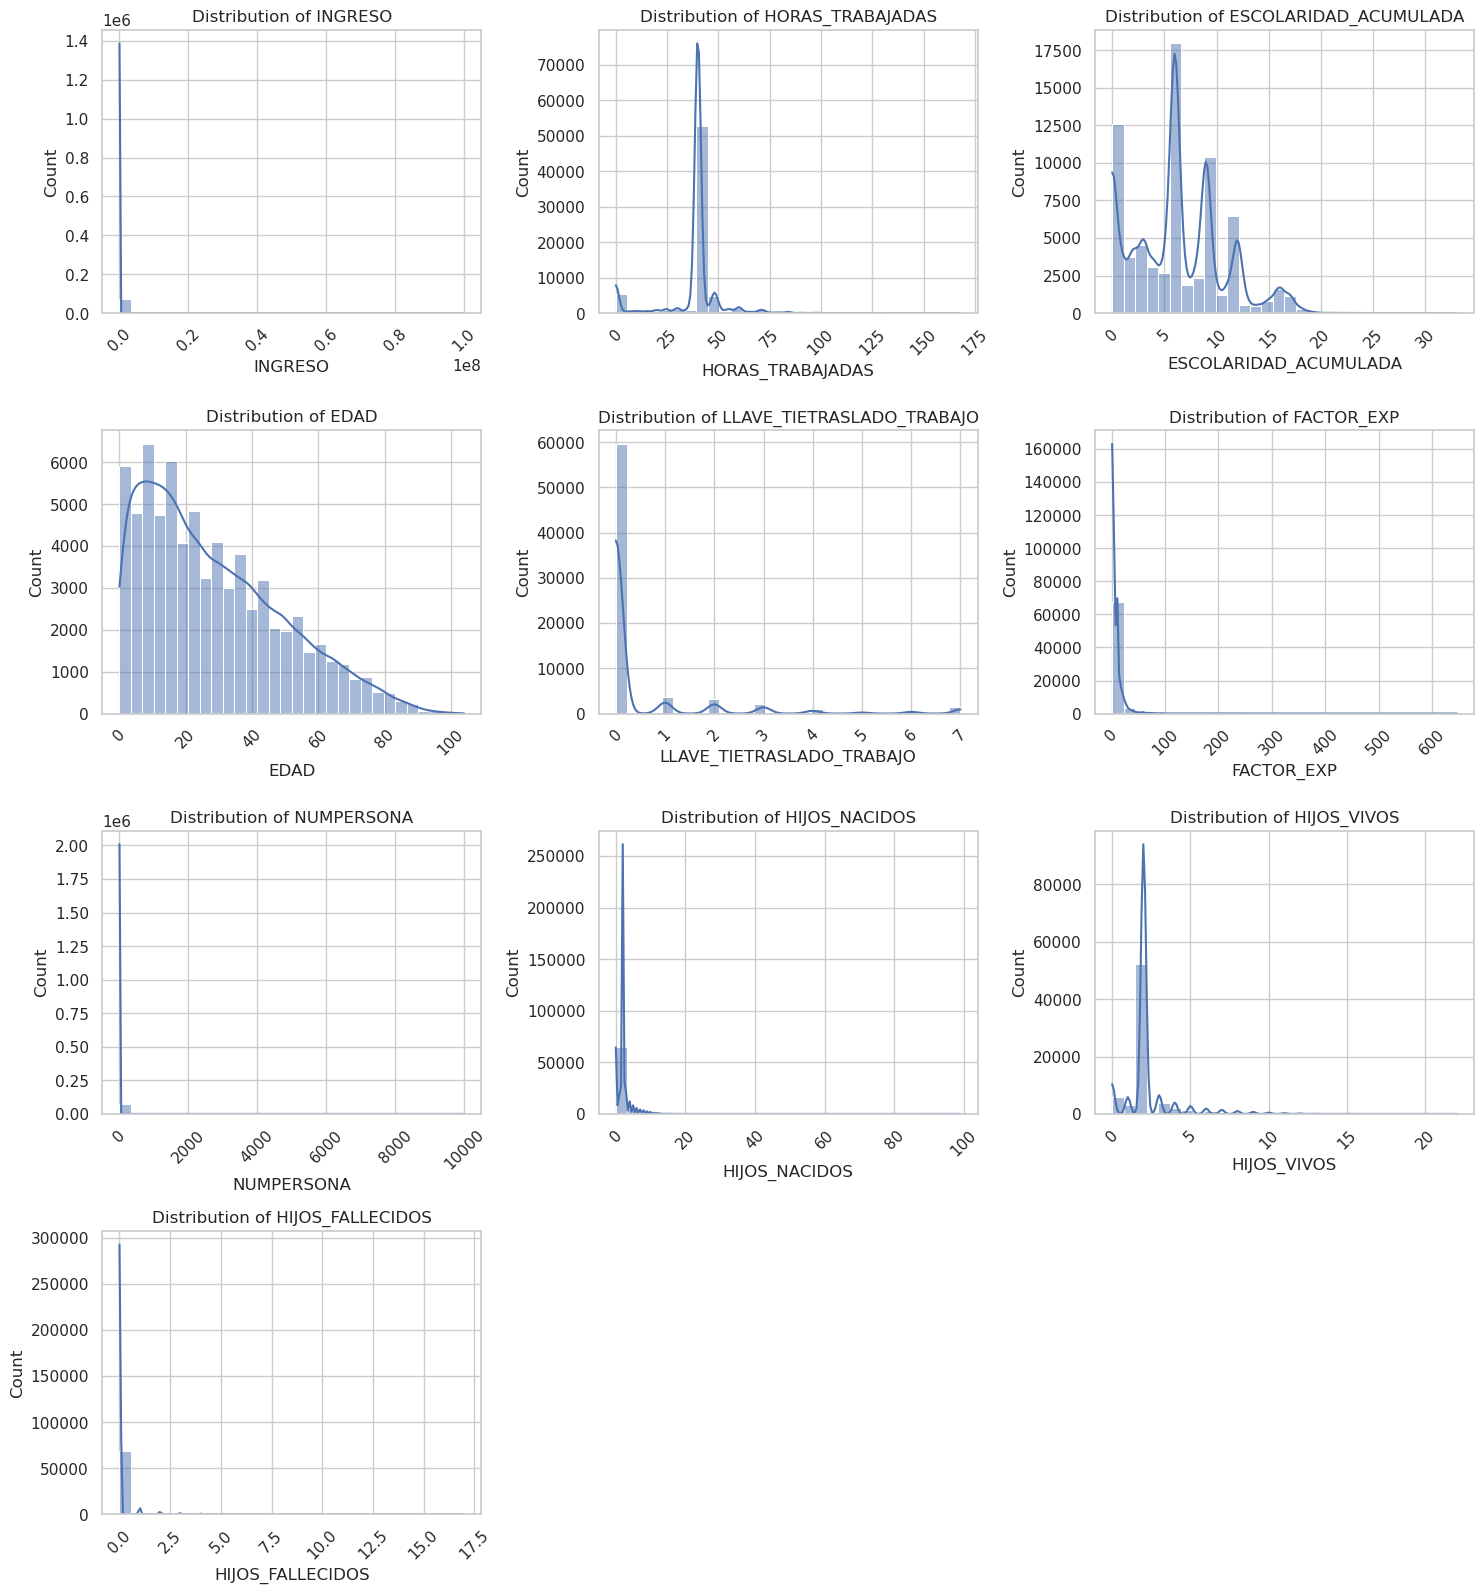

In [127]:
# 3) Plot Continuous Variables (Histograms)
n_cols = 3
n_rows = -(-len(continuous_vars) // n_cols)  # Ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(continuous_vars):
    sns.histplot(data=train_data, x=col, ax=axs[i], kde=True, bins=30)
    axs[i].set_title(f"Distribution of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

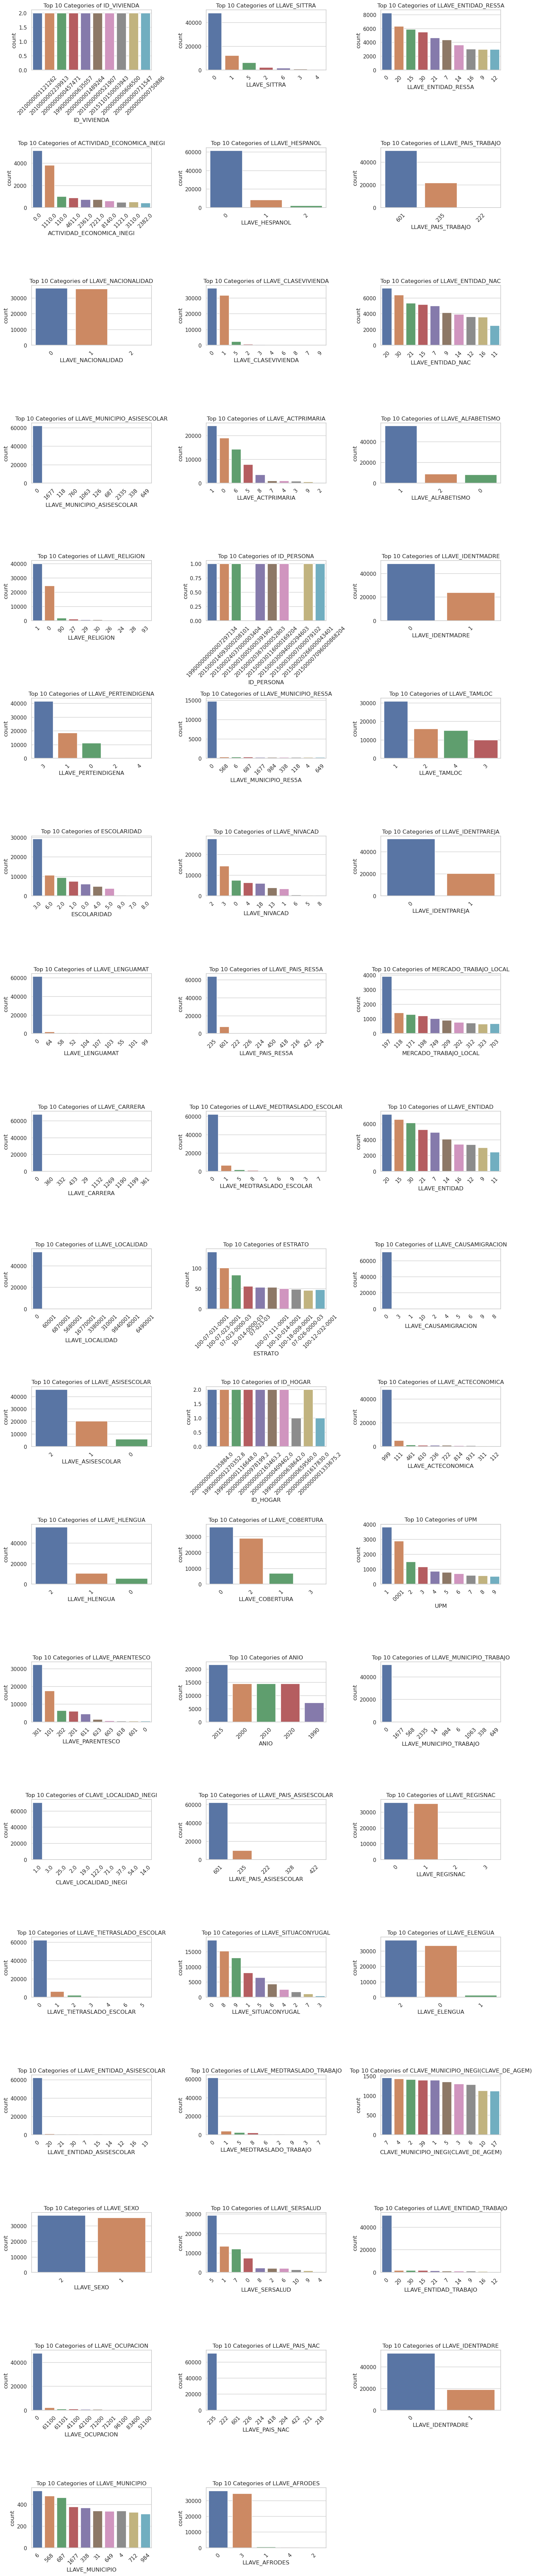

In [128]:
# 4) 4. Plot Categorical Variables (Bar Plots)

n_cols = 3
n_rows = -(-len(categorical_vars) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(data=train_data, x=col, ax=axs[i], order=df[col].value_counts().index[:10])
    axs[i].set_title(f"Top 10 Categories of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

here i choose the variables that have some variation, which is assessed visually, and those who are relevant accordig to the literature, and also if there ar variables that super correlated to others i select it arbitrarely. 

Selection of variables

In [129]:
# 🎯 Target Variable
target_variable = ['INGRESO']

# 🌍 Geographical / Labor Market Context
geographical_context = ['MERCADO_TRABAJO_LOCAL']  # Local Labor Market

# 🛠️ Work and Commute Characteristics
work_characteristics = [
    'HORAS_TRABAJADAS',           # Working hours
    'LLAVE_TIETRASLADO_TRABAJO',  # Commute time to work
    'ACTIVIDAD_ECONOMICA_INEGI',  # Economic sector
    'LLAVE_ACTPRIMARIA'           # Primary activity
]

# 🎓 Education
education_variables = [
    'ESCOLARIDAD_ACUMULADA',      # Accumulated schooling
]

# 🧍 Sociodemographic Characteristics
sociodemographic_variables = [
    'EDAD',                       # Age
    'HIJOS_VIVOS',                 # Number of living children
    'LLAVE_SITUACONYUGAL',        # Marital status
    'LLAVE_PERTEINDIGENA',        # Indigenous identity
    'LLAVE_RELIGION',             # Religion
    'LLAVE_AFRODES',              # Afrodescendant identity
    'LLAVE_SEXO'                  # Sex
]

# ✅ Combine all selected variables into one list
selected_columns = (
    target_variable + 
    geographical_context +
    work_characteristics +
    education_variables +
    sociodemographic_variables
)

# 🎯 Create a new DataFrame with only the selected variables
train_data_selected = train_data[selected_columns].copy()

# 🖨️ Optional: Check shape and preview
print(f"✅ Selected dataset shape: {train_data_selected.shape}")
train_data_selected.head(5)

✅ Selected dataset shape: (72000, 14)


,INGRESO,MERCADO_TRABAJO_LOCAL,HORAS_TRABAJADAS,LLAVE_TIETRASLADO_TRABAJO,ACTIVIDAD_ECONOMICA_INEGI,LLAVE_ACTPRIMARIA,ESCOLARIDAD_ACUMULADA,EDAD,HIJOS_VIVOS,LLAVE_SITUACONYUGAL,LLAVE_PERTEINDIGENA,LLAVE_RELIGION,LLAVE_AFRODES,LLAVE_SEXO
51531,0.0,502,40.0,0.0,NaN,6,17.0,33.0,1.0,5,3,0,3,2
77647,0.0,403,40.0,0.0,NaN,5,6.0,15.0,2.0,9,1,1,3,1
14043,0.0,717,40.0,0.0,NaN,0,1.0,8.0,2.0,0,1,1,0,2
75237,2150.0,217,40.0,2.0,9319.0,1,16.0,42.0,2.0,3,3,1,3,2
44043,0.0,708,40.0,0.0,NaN,6,9.0,41.0,2.0,5,3,0,3,2


In [130]:
train_data_selected.dtypes

INGRESO                       float64
MERCADO_TRABAJO_LOCAL        category
HORAS_TRABAJADAS              float64
LLAVE_TIETRASLADO_TRABAJO     float64
ACTIVIDAD_ECONOMICA_INEGI    category
LLAVE_ACTPRIMARIA            category
ESCOLARIDAD_ACUMULADA         float64
EDAD                          float64
HIJOS_VIVOS                   float64
LLAVE_SITUACONYUGAL          category
LLAVE_PERTEINDIGENA          category
LLAVE_RELIGION               category
LLAVE_AFRODES                category
LLAVE_SEXO                   category
dtype: object

Correlation analysis

INGRESO                      1.000000
ESCOLARIDAD_ACUMULADA        0.011076
LLAVE_TIETRASLADO_TRABAJO    0.010658
EDAD                         0.003682
HORAS_TRABAJADAS             0.002342
HIJOS_VIVOS                 -0.001199
Name: INGRESO, dtype: float64


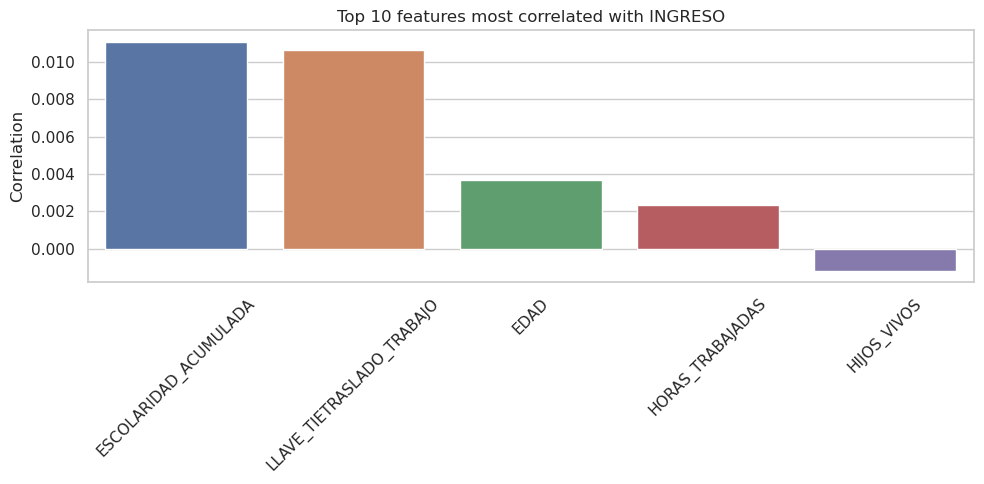

In [131]:
# Step 2: Select only numeric columns
num_vars = train_data_selected.select_dtypes(include=['int64', 'float64'])

# Step 3: Compute correlation with the target variable
correlations = num_vars.corr()['INGRESO'].sort_values(ascending=False)

# Step 4: Display correlations
print(correlations)

# Step 5: Plot top 10 most correlated features with INGRESO
plt.figure(figsize=(10, 5))
sns.barplot(x=correlations.index[1:11], y=correlations.values[1:11])  # skip 'INGRESO' itself
plt.xticks(rotation=45)
plt.title("Top 10 features most correlated with INGRESO")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

In [132]:
# Get categorical columns
cat_vars = train_data_selected.select_dtypes(include='category').columns

# Count number of unique categories for each categorical variable
category_counts = {col: train_data_selected[col].nunique() for col in cat_vars}


category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Num Categories'])

# Sort by number of categories (optional)
category_counts_df = category_counts_df.sort_values(by='Num Categories', ascending=False)

# Display
print(category_counts_df)

                           Num Categories
MERCADO_TRABAJO_LOCAL                 775
ACTIVIDAD_ECONOMICA_INEGI             439
LLAVE_RELIGION                         79
LLAVE_ACTPRIMARIA                      10
LLAVE_SITUACONYUGAL                    10
LLAVE_PERTEINDIGENA                     5
LLAVE_AFRODES                           5
LLAVE_SEXO                              2


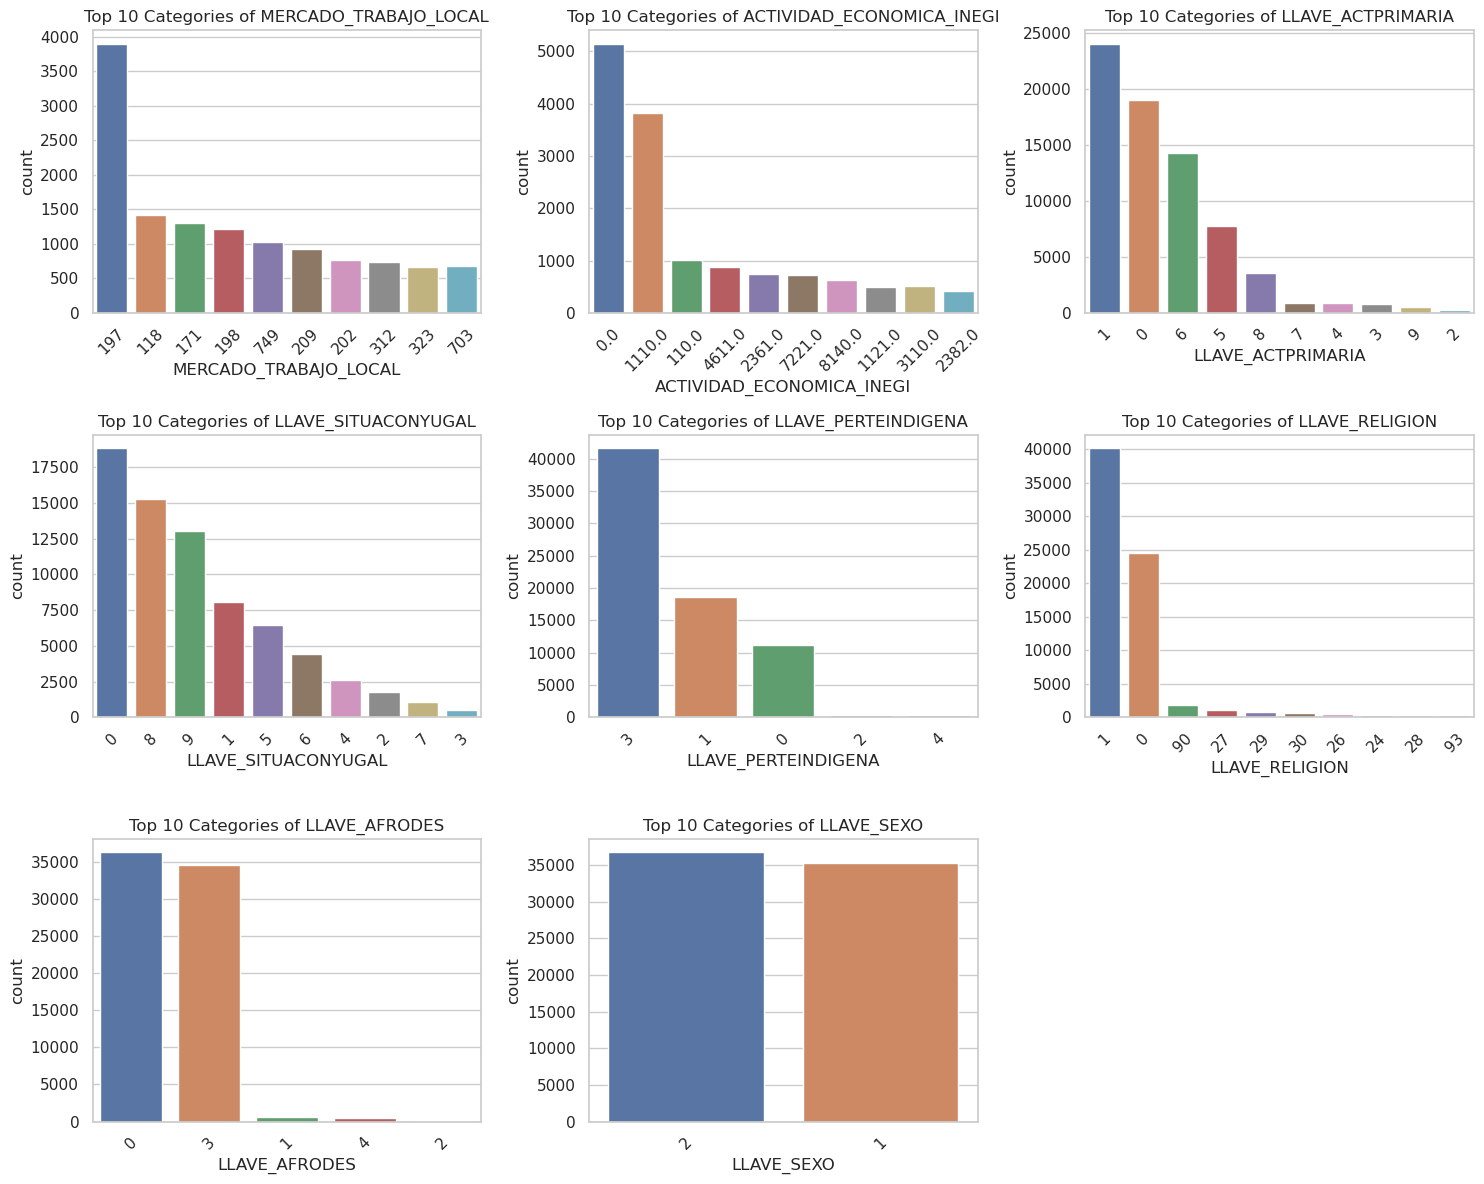

In [133]:
# 4) 4. Plot Categorical Variables (Bar Plots)
n_cols = 3
n_rows = -(-len(cat_vars) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(data=train_data_selected, x=col, ax=axs[i], order=df[col].value_counts().index[:10])
    axs[i].set_title(f"Top 10 Categories of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

To include these categorical variables in the regression i am going to transform them according to the number of categories that each variable has. 

For low-cardinality variables (≤ 10 categories) Use One-Hot Encoding
For Medium/high-cardinality variables (≫ 10 categories)
Instead, you can:
	•	Use Target Encoding (Mean Encoding)
	•	Use Frequency Encoding
	•	Use Ordinal encoding (if you know there’s a logical order)
	•	Use Embeddings if you’re considering neural networks in future steps


In [19]:
from sklearn.feature_selection import mutual_info_regression

cat_vars = df_selected.select_dtypes(include='category').columns
X_cat = pd.get_dummies(df_selected[cat_vars], drop_first=True)
mi = mutual_info_regression(X_cat, df['INGRESO'])

# Mostrar top variables
mi_series = pd.Series(mi, index=X_cat.columns).sort_values(ascending=False)
print(mi_series.head(10))

KeyboardInterrupt: 

Categorical Variables Embedding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Asignar IDs únicos
categorical_cols = ['LLAVE_OCUPACION', 'LLAVE_SITTRA', 'LLAVE_ACTPRIMARIA', 'LLAVE_RELIGION', 'LLAVE_SEXO', 'MERCADO_TRABAJO_LOCAL']
df_encoded = df.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Guardar por si necesitas invertirlo luego

Analysis

In [ ]:
# Import train_test_split.
from sklearn.model_selection import train_test_split


# Create features X and target y.
X = pd.DataFrame(df, columns=housing.feature_names)[["AveRooms"]]
y = housing.target  # Median house value in $100,000s


# Split the dataset into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Read in California housing dataset.
from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices